# LSTM for Cancer Text Classification
**Model:** Long Short-Term Memory (LSTM)

**Embeddings:** TF-IDF, Skip-gram (Word2Vec), CBOW (Word2Vec)

**Dataset:** Medical Text Dataset – Cancer Doc Classification


## 1. Imports & Setup

In [2]:
!pip install gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from gensim.models import Word2Vec

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU Available: {tf.config.list_physical_devices("GPU")}')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


2026-02-08 11:23:47.200482: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-08 11:23:47.587336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-08 11:23:49.710317: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
GPU Available: []


2026-02-08 11:23:50.626553: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



## 2. Load Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the preprocessed data from your EDA notebook
df=pd.read_csv('/home/belysetag/Desktop/text-classification-nlp/data/preprocessed_data.csv.zip', encoding='latin1')




## 3. Train/Test Split (SHARED SEED = 42)

In [ ]:
RANDOM_SEED = 42

X = df['clean_text']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

print(f'Train: {len(X_train)}  |  Test: {len(X_test)}')
print(f'\nTrain class distribution:\n{y_train.value_counts()}')
print(f'\nTest class distribution:\n{y_test.value_counts()}')

Train: 6056  |  Test: 1514

Train class distribution:
label_encoded
2    2248
0    2064
1    1744
Name: count, dtype: int64

Test class distribution:
label_encoded
2    562
0    516
1    436
Name: count, dtype: int64



## 4. Functions

In [ ]:
# Evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'\n{"="*60}')
    print(f'  {model_name}')
    print('='*60)
    print(f'Accuracy:  {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall:    {rec:.4f}')
    print(f'F1-Score:  {f1:.4f}')

    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}

# Confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    classes = ['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Training history plot
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title(f'{title} — Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title(f'{title} — Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# EMBEDDING 1: TF-IDF


## 5. TF-IDF Feature Extraction

In [ ]:
# TF-IDF vectorization with max features to keep dimensionality manageable
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print(f'TF-IDF Train shape: {X_train_tfidf.shape}')
print(f'TF-IDF Test shape:  {X_test_tfidf.shape}')

TF-IDF Train shape: (6056, 5000)
TF-IDF Test shape:  (1514, 5000)


## 6. Build LSTM Model (TF-IDF)

In [ ]:
# For TF-IDF, we treat each document as a sequence of features
# Reshape: (samples, features) → (samples, timesteps=1, features)
X_train_tfidf_seq = X_train_tfidf.reshape((X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_test_tfidf_seq = X_test_tfidf.reshape((X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))

print(f'Reshaped TF-IDF for LSTM: {X_train_tfidf_seq.shape}')

Reshaped TF-IDF for LSTM: (6056, 1, 5000)


In [ ]:
# Build LSTM model
model_tfidf = Sequential([
    LSTM(128, input_shape=(1, 5000), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_tfidf.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_tfidf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │     2,626,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,679,811 (10.22 MB)

 Trainable params: 2,679,811 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train LSTM (TF-IDF)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train
history_tfidf = model_tfidf.fit(
    X_train_tfidf_seq, y_train,
    validation_split=0.15,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5053 - loss: 0.9116 - val_accuracy: 0.8889 - val_loss: 0.2305 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9329 - loss: 0.1719 - val_accuracy: 0.9252 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9396 - loss: 0.1252 - val_accuracy: 0.9252 - val_loss: 0.1184 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9531 - loss: 0.0973 - val_accuracy: 0.9384 - val_loss: 0.1119 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9588 - loss: 0.0857 - val_accuracy: 0.9483 - val_loss: 0.0947 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9598 - loss: 0.0819 - val_accuracy: 0.9549 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9577 - loss

## 8. Evaluate LSTM (TF-IDF)

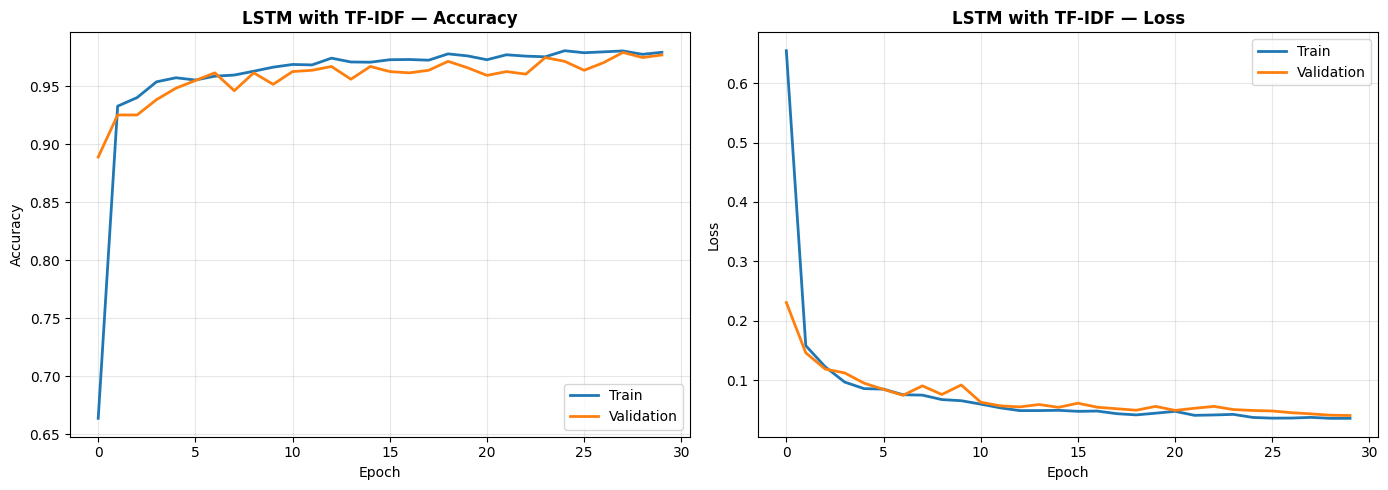

In [ ]:
# Plot training history
plot_training_history(history_tfidf, 'LSTM with TF-IDF')

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

  LSTM with TF-IDF
Accuracy:  0.9742
Precision: 0.9760
Recall:    0.9757
F1-Score:  0.9758


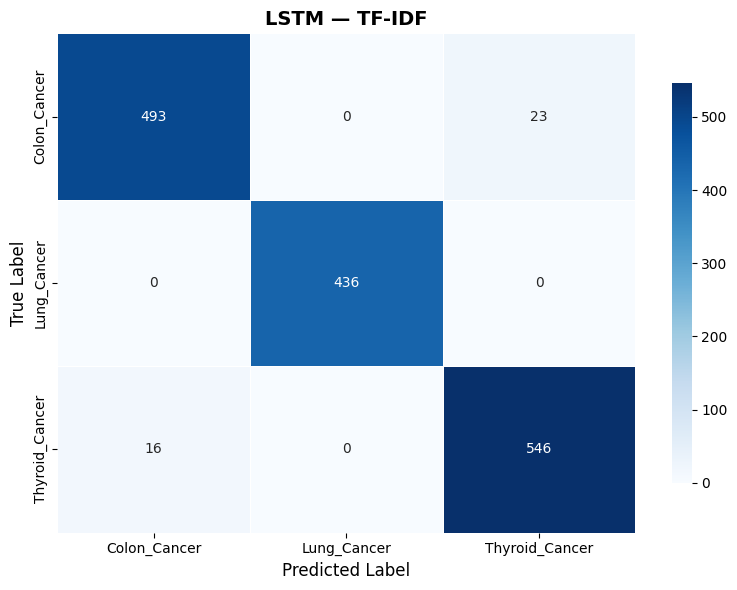

In [ ]:
# Predictions
y_pred_tfidf_prob = model_tfidf.predict(X_test_tfidf_seq)
y_pred_tfidf = np.argmax(y_pred_tfidf_prob, axis=1)

# Metrics
results_tfidf = evaluate_model(y_test, y_pred_tfidf, 'LSTM with TF-IDF')

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_tfidf, 'LSTM — TF-IDF')

In [ ]:
# Classification report
print(classification_report(y_test, y_pred_tfidf,
                           target_names=['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer']))

                precision    recall  f1-score   support

  Colon_Cancer       0.97      0.96      0.96       516
   Lung_Cancer       1.00      1.00      1.00       436
Thyroid_Cancer       0.96      0.97      0.97       562

      accuracy                           0.97      1514
     macro avg       0.98      0.98      0.98      1514
  weighted avg       0.97      0.97      0.97      1514




# EMBEDDING 2: Skip-gram (Word2Vec)


## 9. Tokenize & Pad Sequences

In [ ]:
# For Word2Vec embeddings, we need sequences of token indices
MAX_VOCAB_SIZE = 50000
MAX_SEQ_LENGTH = 500  # Adjust based on your text length analysis

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

print(f'Vocabulary size: {vocab_size}')
print(f'Train sequences shape: {X_train_pad.shape}')
print(f'Test sequences shape:  {X_test_pad.shape}')

Vocabulary size: 50000
Train sequences shape: (6056, 500)
Test sequences shape:  (1514, 500)


## 10. Train Skip-gram Word2Vec

In [ ]:
# Prepare sentences for Word2Vec training
X_train_tokens = X_train.apply(lambda x: x.split()).tolist()

# Train Skip-gram model
EMBEDDING_DIM = 150

w2v_skipgram = Word2Vec(
    sentences=X_train_tokens,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    sg=1,  # Skip-gram
    epochs=20,
    workers=4,
    seed=RANDOM_SEED
)

print(f'Skip-gram vocabulary size: {len(w2v_skipgram.wv)}')
print(f'Embedding dimension: {EMBEDDING_DIM}')

Skip-gram vocabulary size: 252500
Embedding dimension: 150


## 11. Build Embedding Matrix (Skip-gram)

In [ ]:
# Create embedding matrix from Word2Vec model
embedding_matrix_sg = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    if word in w2v_skipgram.wv:
        embedding_matrix_sg[idx] = w2v_skipgram.wv[word]

print(f'Embedding matrix shape: {embedding_matrix_sg.shape}')
print(f'Non-zero vectors: {np.count_nonzero(np.sum(embedding_matrix_sg, axis=1))}/{vocab_size}')

Embedding matrix shape: (50000, 150)
Non-zero vectors: 43113/50000


## 12. Build LSTM Model (Skip-gram)

In [ ]:
model_sg = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix_sg],
        input_length=MAX_SEQ_LENGTH,
        trainable=False  # Freeze pre-trained embeddings
    ),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_sg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_sg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,500,000 (28.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,500,000 (28.61 MB)

## 13. Train LSTM (Skip-gram)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history_sg = model_sg.fit(
    X_train_pad, y_train,
    validation_split=0.15,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.5257 - loss: 0.9021 - val_accuracy: 0.7008 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6685 - loss: 0.6375 - val_accuracy: 0.7437 - val_loss: 0.5515 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7637 - loss: 0.5013 - val_accuracy: 0.8537 - val_loss: 0.3373 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8488 - loss: 0.3771 - val_accuracy: 0.8977 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8706 - loss: 0.3176 - val_accuracy: 0.8801 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9191 - loss: 0.1895 - val_accuracy: 0.9186 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9291 - loss: 0.

## 14. Evaluate LSTM (Skip-gram)

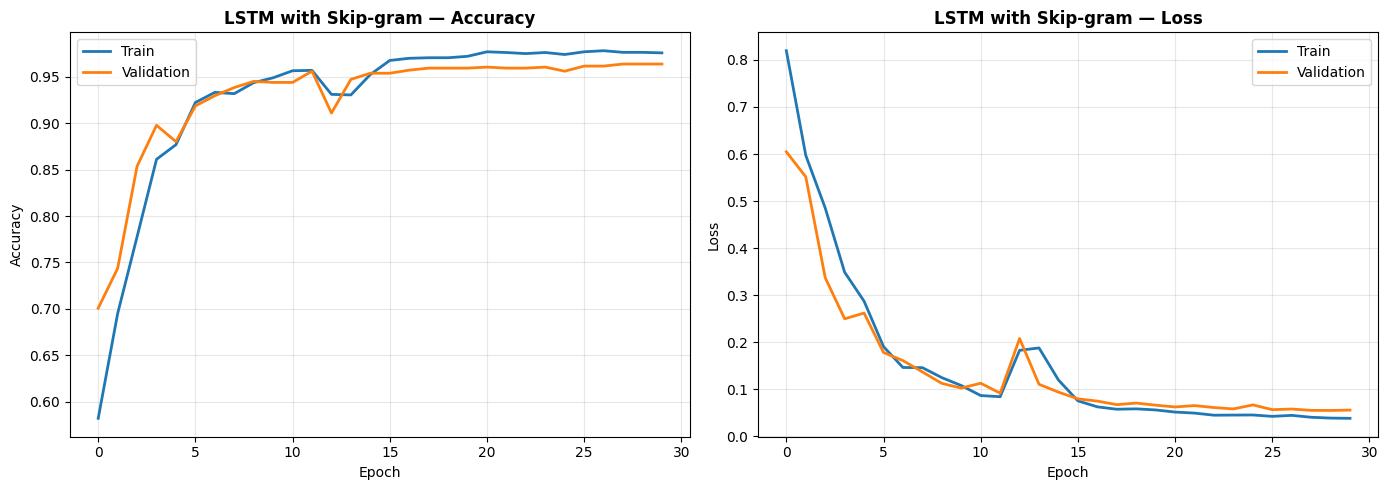

In [ ]:
plot_training_history(history_sg, 'LSTM with Skip-gram')

48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 381ms/step

  LSTM with Skip-gram (Word2Vec)
Accuracy:  0.9716
Precision: 0.9726
Recall:    0.9732
F1-Score:  0.9729


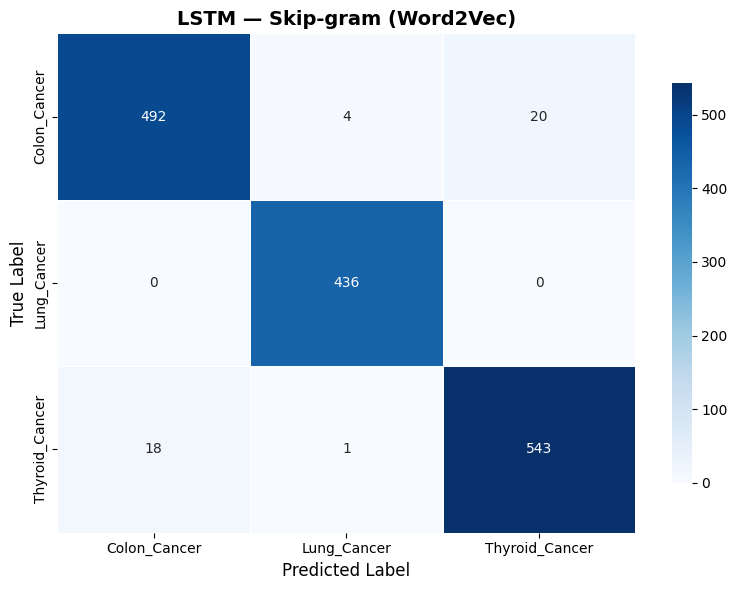

In [ ]:
y_pred_sg_prob = model_sg.predict(X_test_pad)
y_pred_sg = np.argmax(y_pred_sg_prob, axis=1)

results_sg = evaluate_model(y_test, y_pred_sg, 'LSTM with Skip-gram (Word2Vec)')

plot_confusion_matrix(y_test, y_pred_sg, 'LSTM — Skip-gram (Word2Vec)')

In [ ]:
print(classification_report(y_test, y_pred_sg,
                           target_names=['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer']))

                precision    recall  f1-score   support

  Colon_Cancer       0.96      0.95      0.96       516
   Lung_Cancer       0.99      1.00      0.99       436
Thyroid_Cancer       0.96      0.97      0.97       562

      accuracy                           0.97      1514
     macro avg       0.97      0.97      0.97      1514
  weighted avg       0.97      0.97      0.97      1514




# EMBEDDING 3: CBOW (Word2Vec)


## 15. Train CBOW Word2Vec

In [ ]:
# Train CBOW model (sg=0)
w2v_cbow = Word2Vec(
    sentences=X_train_tokens,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    sg=0,  # CBOW
    epochs=20,
    workers=4,
    seed=RANDOM_SEED
)

print(f'CBOW vocabulary size: {len(w2v_cbow.wv)}')
print(f'Embedding dimension: {EMBEDDING_DIM}')

CBOW vocabulary size: 252500
Embedding dimension: 150


## 16. Build Embedding Matrix (CBOW)

In [ ]:
embedding_matrix_cbow = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    if word in w2v_cbow.wv:
        embedding_matrix_cbow[idx] = w2v_cbow.wv[word]

print(f'Embedding matrix shape: {embedding_matrix_cbow.shape}')
print(f'Non-zero vectors: {np.count_nonzero(np.sum(embedding_matrix_cbow, axis=1))}/{vocab_size}')

Embedding matrix shape: (50000, 150)
Non-zero vectors: 43113/50000


## 17. Build LSTM Model (CBOW)

In [ ]:
model_cbow = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix_cbow],
        input_length=MAX_SEQ_LENGTH,
        trainable=False
    ),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_cbow.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cbow.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,500,000 (28.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,500,000 (28.61 MB)

## 18. Train LSTM (CBOW)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history_cbow = model_cbow.fit(
    X_train_pad, y_train,
    validation_split=0.15,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5680 - loss: 0.8409 - val_accuracy: 0.8229 - val_loss: 0.3848 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8742 - loss: 0.2936 - val_accuracy: 0.9197 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9310 - loss: 0.1781 - val_accuracy: 0.9428 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9480 - loss: 0.1074 - val_accuracy: 0.9483 - val_loss: 0.0962 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9612 - loss: 0.0830 - val_accuracy: 0.9571 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9569 - loss: 0.0989 - val_accuracy: 0.9450 - val_loss: 0.1101 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9631 - loss: 0.

## 19. Evaluate LSTM (CBOW)

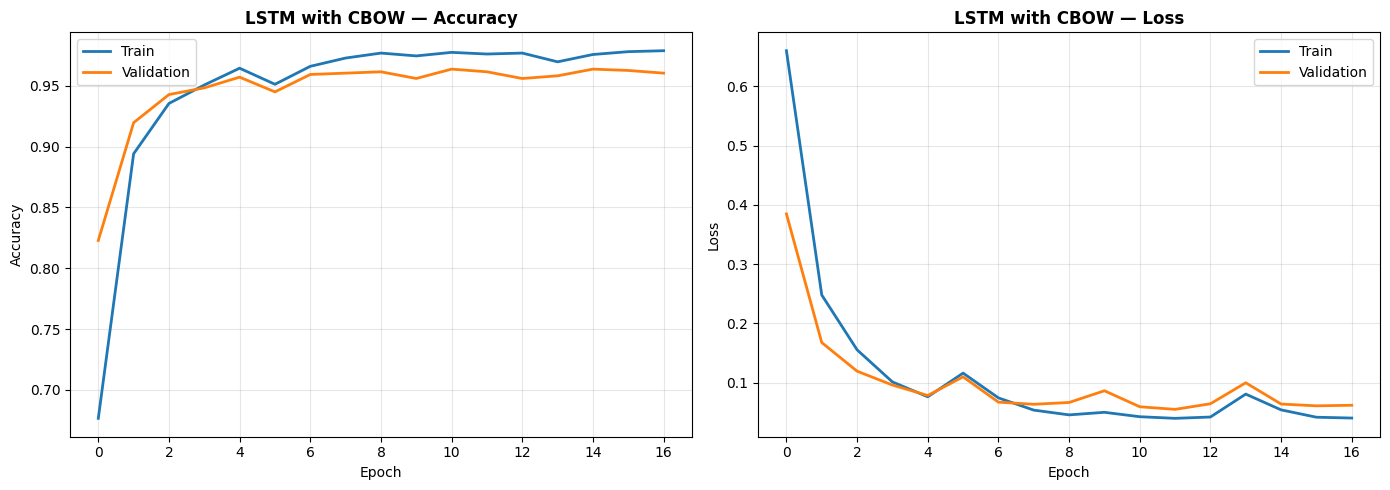

In [ ]:
plot_training_history(history_cbow, 'LSTM with CBOW')

48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step

  LSTM with CBOW (Word2Vec)
Accuracy:  0.9736
Precision: 0.9751
Recall:    0.9756
F1-Score:  0.9752


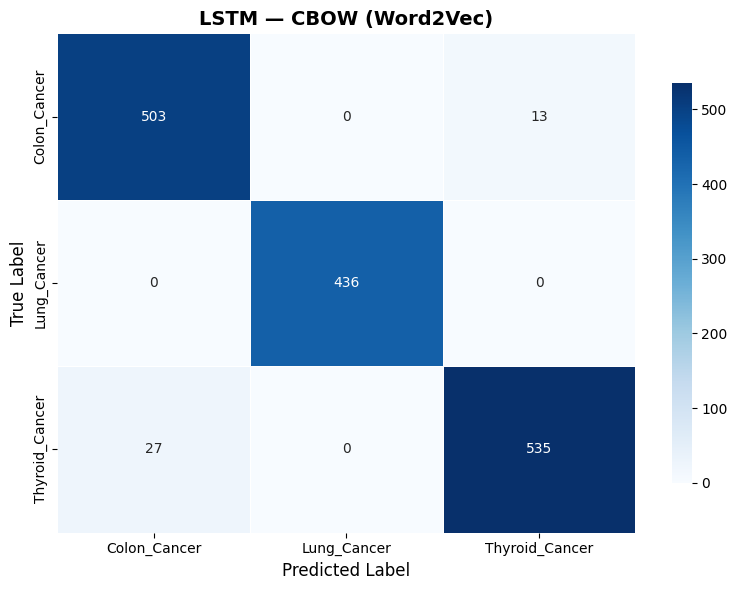

In [ ]:
y_pred_cbow_prob = model_cbow.predict(X_test_pad)
y_pred_cbow = np.argmax(y_pred_cbow_prob, axis=1)

results_cbow = evaluate_model(y_test, y_pred_cbow, 'LSTM with CBOW (Word2Vec)')

plot_confusion_matrix(y_test, y_pred_cbow, 'LSTM — CBOW (Word2Vec)')

In [ ]:
print(classification_report(y_test, y_pred_cbow,
                           target_names=['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer']))

                precision    recall  f1-score   support

  Colon_Cancer       0.95      0.97      0.96       516
   Lung_Cancer       1.00      1.00      1.00       436
Thyroid_Cancer       0.98      0.95      0.96       562

      accuracy                           0.97      1514
     macro avg       0.98      0.98      0.98      1514
  weighted avg       0.97      0.97      0.97      1514




# FINAL COMPARISON — All 3 Embeddings

In [ ]:
# Summary comparison table
summary = pd.DataFrame({
    'Embedding': ['TF-IDF', 'Skip-gram (Word2Vec)', 'CBOW (Word2Vec)'],
    'Accuracy': [
        results_tfidf['Accuracy'],
        results_sg['Accuracy'],
        results_cbow['Accuracy']
    ],
    'Precision (macro)': [
        results_tfidf['Precision'],
        results_sg['Precision'],
        results_cbow['Precision']
    ],
    'Recall (macro)': [
        results_tfidf['Recall'],
        results_sg['Recall'],
        results_cbow['Recall']
    ],
    'F1 (macro)': [
        results_tfidf['F1'],
        results_sg['F1'],
        results_cbow['F1']
    ]
})

print('\n' + '='*70)
print('  LSTM — FINAL RESULTS COMPARISON')
print('='*70)
print(summary.to_string(index=False))
print('='*70)


  LSTM — FINAL RESULTS COMPARISON
           Embedding  Accuracy  Precision (macro)  Recall (macro)  F1 (macro)
              TF-IDF  0.974240           0.976048        0.975652    0.975823
Skip-gram (Word2Vec)  0.971598           0.972615        0.973227    0.972899
     CBOW (Word2Vec)  0.973580           0.975111        0.975588    0.975241


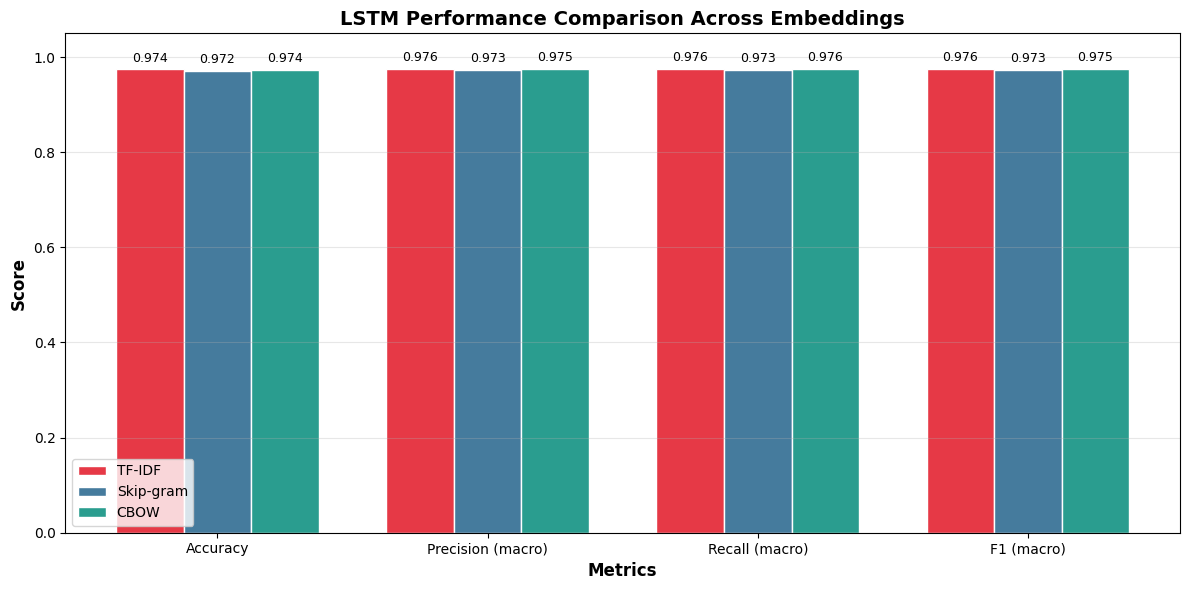

In [ ]:
# Bar chart comparison
metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

vals_tfidf = summary.loc[summary['Embedding'] == 'TF-IDF', metrics].values[0]
vals_sg = summary.loc[summary['Embedding'] == 'Skip-gram (Word2Vec)', metrics].values[0]
vals_cbow = summary.loc[summary['Embedding'] == 'CBOW (Word2Vec)', metrics].values[0]

bars1 = ax.bar(x - width, vals_tfidf, width, label='TF-IDF', color='#e63946', edgecolor='white')
bars2 = ax.bar(x, vals_sg, width, label='Skip-gram', color='#457b9d', edgecolor='white')
bars3 = ax.bar(x + width, vals_cbow, width, label='CBOW', color='#2a9d8f', edgecolor='white')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('LSTM Performance Comparison Across Embeddings', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('lstm_comparison.png', dpi=150, bbox_inches='tight')
plt.show()